In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression

In [2]:
import sys
sys.path.append('../stan/')
from stan_utilities import get_model

## Step 1: Load raw data

In [3]:
data_dir = '../data/'
! ls -la $data_dir

total 8608
drwxr-xr-x  12 peterkomar  staff      408 Jun  8 10:55 .
drwxr-xr-x  10 peterkomar  staff      340 Jun  8 13:32 ..
-rw-r--r--@  1 peterkomar  staff   548708 Jun  8 12:48 vial15a_OD.txt
-rw-r--r--@  1 peterkomar  staff      515 Jun  8 10:49 vial15a_pump_log.txt
-rw-r--r--@  1 peterkomar  staff  1015250 Jun  8 10:50 vial15b_OD.txt
-rw-r--r--@  1 peterkomar  staff     4369 Jun  8 10:50 vial15b_pump_log.txt
-rw-r--r--@  1 peterkomar  staff   894367 Jun  8 10:49 vial5_OD.txt
-rw-r--r--@  1 peterkomar  staff     2694 Jun  8 10:49 vial5_pump_log.txt
-rw-r--r--@  1 peterkomar  staff  1014933 Jun  8 10:50 vial6_OD.txt
-rw-r--r--@  1 peterkomar  staff     2836 Jun  8 10:50 vial6_pump_log.txt
-rw-r--r--@  1 peterkomar  staff   900535 Jun  8 10:49 vial8_OD.txt
-rw-r--r--@  1 peterkomar  staff     4692 Jun  8 10:49 vial8_pump_log.txt


In [4]:
files = ! ls $data_dir

In [5]:
data_files = {}
for f in files:
    name = f.split('_')[0]
    typ = '_'.join(f.split('.')[0].split('_')[1:])
    if name not in data_files: data_files[name] = {}
    data_files[name][typ] = os.path.join(data_dir, f)

In [6]:
data = {}
for name, files in data_files.items():
    d = {}
    data[name] = d
    d['OD'] = pd.read_csv(files['OD'], sep=',', names=['time', 'OD'], header=0)
    d['pump_log'] = pd.read_csv(files['pump_log'], sep=',', names=['time', 'OD'], header=0)

In [326]:
time = np.array(data['vial15a']['OD']['time'])
od = np.array(data['vial15a']['OD']['OD'])

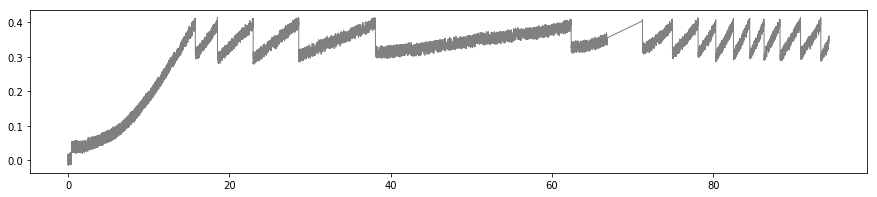

In [327]:
plt.figure(figsize=(15,3))
plt.plot(time, od, '-', lw=1, color='gray')
plt.show()

## Step 2: Find top and bottom log-OD thresholds

In [328]:
def get_center_and_width(time, od):
    
    # Step 1: remove non-positive OD
    positive_od = od > 0
    od_pos = od[positive_od]
    
    # Step 2: determine width
    model = get_model('../stan/width_estimation_model.stan', 
                      '../stan/width_estimation_model.pkl')
    log_OD = np.log(od_pos)
    
    data_dict = {
    'N': len(log_OD),
    'x': log_OD
    }
    mu0 = np.median(log_OD)
    sigma0 = 2*(np.percentile(log_OD, 75) - np.percentile(log_OD, 25))
    fit = model.optimizing(data_dict, init=lambda : 
                              {
                                  'mu': mu0,
                                  'sigma': sigma0,
                                  'm': mu0,
                                  's': 3 * sigma0,
                                  'w': [0.8, 0.2]
                              }
                            )
    width = np.sqrt(12) * fit['sigma']
    center = fit['mu']
    
    return center, width

In [329]:
log_od_center, log_od_width = get_center_and_width(time, od)
np.exp(log_od_center - 0.5*log_od_width), np.exp(log_od_center + 0.5*log_od_width),

(0.2998870368915642, 0.3944435857747305)

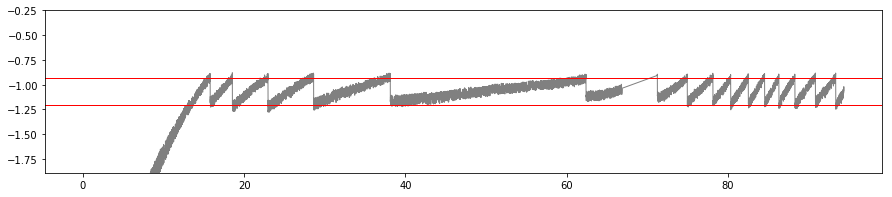

In [330]:
plt.figure(figsize=(15,3))
plt.plot(time[od > 0], np.log(od[od > 0]), '-', lw=1, color='gray', )
low = log_od_center - log_od_width / 2
high = log_od_center + log_od_width / 2
plt.axhline(low, color='r', lw=1)
plt.axhline(high, color='r', lw=1)
plt.ylim([log_od_center - 3*log_od_width, log_od_center + 3*log_od_width])
plt.show()

## Step 3: Estimate overall frequency of dilutions

**Step 3a:** Find longest contiguous segment

In [331]:
def find_longest_segment(time, od, log_od_center, log_od_width, width_factor=1.5):
    low_od = np.exp(log_od_center - width_factor * log_od_width / 2)
    high_od = np.exp(log_od_center + width_factor * log_od_width / 2)
    selection = (low_od < od) & (od < high_od)
    
    segment_start_flag = np.diff(selection.astype(int))
    segment_start_idx = np.where(segment_start_flag == 1)[0] + 1
    segment_end_idx = np.where(segment_start_flag == -1)[0]
    if len(segment_end_idx) < len(segment_start_idx):
        segment_end_idx = np.concatenate([segment_end_idx, [len(selection) - 1]])
    assert len(segment_end_idx) == len(segment_start_idx)

    segment_lengths = segment_end_idx - segment_start_idx
    longest_segment = np.argmax(segment_lengths)
    longest_segment_start_idx = np.arange(len(time))[segment_start_idx][longest_segment]
    longest_segment_end_idx = np.arange(len(time))[segment_end_idx][longest_segment]

    return (np.arange(len(time)) >= longest_segment_start_idx) & \
           (np.arange(len(time)) <= longest_segment_end_idx)

In [332]:
longest_segment = find_longest_segment(time, od, log_od_center, log_od_width)
time[longest_segment][[0, -1]]

array([23.101 , 94.3549])

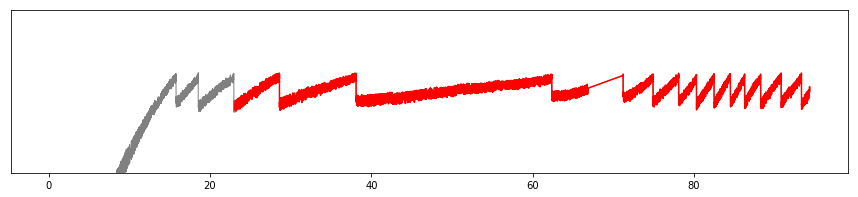

In [333]:
plt.figure(figsize=(15,3))
plt.plot(time[od > 0], np.log(od[od > 0]), 'gray', '-', lw=1)
plt.plot(time[longest_segment], np.log(od[longest_segment]), 'r-')
plt.ylim([log_od_center - 3*log_od_width, log_od_center + 3*log_od_width])
plt.show()

**Step 3b:** Find dominant frequency

In [334]:
def get_main_freq(t, x):
    t_uniform = np.linspace(t[0], t[-1], len(t))
    x_interp = np.interp(t_uniform, t, x)
    x_fft_power = np.abs(np.fft.rfft(x_interp - np.mean(x_interp)))
    main_freq = np.argmax(x_fft_power) / float(t[-1] - t[0] + t[1] - t[0])
    return main_freq

In [349]:
main_freq = get_main_freq(time[longest_segment], np.log(od[longest_segment]))
main_freq, 60.0 / main_freq, 60.0/main_freq / (np.log2(np.exp(log_od_center + 0.5 * log_od_width) / 
                                            np.exp(log_od_center - 0.5 * log_od_width)))

(0.014033571108806486, 4275.462, 10813.009563829763)

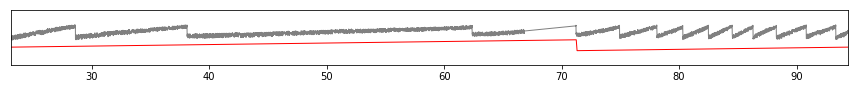

In [350]:
def saw_tooth(t, freq, width=1, y0=0):
    return y0 + width * ( (t * freq) % 1 ) - width / 2.0

plt.figure(figsize=(15, 1))
plt.plot(time[longest_segment], 
         np.log(od[longest_segment]), 
         'gray', '-', lw=1)

time_grid = np.linspace(time[longest_segment][0], time[longest_segment][-1], 1000)
plt.plot(time_grid, 
         - 1.2*log_od_width + log_od_center + log_od_width * saw_tooth(time_grid, main_freq), 
         'r-', lw=1)

plt.xlim(time[longest_segment][[0, -1]])
plt.ylim([log_od_center - 3*log_od_width, log_od_center + 2*log_od_width])
plt.show()

## Step 4: Determine region boundaries, compile cleaned data

In [408]:
def determine_regions(time, od, log_od_center, log_od_width, main_freq,
                      width_factor=1.2,
                      drift_tempering_factor=0.2,
                      jump_margin_factor=0.02,
                      min_datapoints=5,
                      min_duration_factor=0.3,
                      min_datapoint_density_factor=0.1):
    
    # step 1: Drop values outside of low and high thresholds
    low_od = np.exp(log_od_center - width_factor * log_od_width / 2)
    high_od = np.exp(log_od_center + width_factor * log_od_width / 2)
    selection = (low_od < od) & (od < high_od)
    t = time[selection]
    x = np.log(od[selection])
    
    # step 2: Find unambiguous jump locations
    mu_est = width * main_freq
    drift = drift_tempering_factor * mu_est
    number_of_periods = main_freq * (t[-1] - t[0])
    x_drifting = x - drift * t
    iso_reg = IsotonicRegression(increasing=False).fit(t, x_drifting)
    x_segmented = iso_reg.predict(t)
    jump_indexes = np.arange(len(t)-1)[np.diff(x_segmented) < 0]
    
    # step 3: Convert jump locations to start and (inclusive) end locations
    jump_margin = jump_margin_factor / main_freq
    start_indexes = np.concatenate([[0], jump_indexes + 1])
    end_indexes = np.concatenate([jump_indexes, [len(t)-1]])
    for r, (s_idx, e_idx) in enumerate(zip(start_indexes, end_indexes)):
        new_s_idx = np.argmax(t > (t[s_idx] + jump_margin / 2))
        new_e_idx = np.argmin(t < (t[e_idx] - jump_margin / 2))            
        if new_s_idx > s_idx:
            start_indexes[r] = new_s_idx
        if new_e_idx < e_idx:
            end_indexes[r] = new_e_idx
        if end_indexes[r] < start_indexes[r]:
            end_indexes[r] = start_indexes[r]
        
    # step 4: Drop regions with too little or anomalous data
    datapoints = end_indexes - start_indexes + 1
    durations = t[end_indexes] - t[start_indexes]
    datapoint_density = datapoints / np.min(durations + (t[-1] - t[0]) / len(t))
    selected_regions = (datapoints >= min_datapoints) & \
                       (durations >= min_duration_factor / main_freq) & \
                       (datapoint_density >= min_datapoint_density_factor * len(t) / (t[-1] - t[0]))
    s = start_indexes[selected_regions]
    e = end_indexes[selected_regions]
    
    # step 5: compile cleanedt and x
    regions = np.concatenate([np.arange(len(time))[sr:er+1] for (sr, er) in zip(s, e)])
    t_final = t[regions]
    x_final = x[regions]
    
    return t, x, s, e

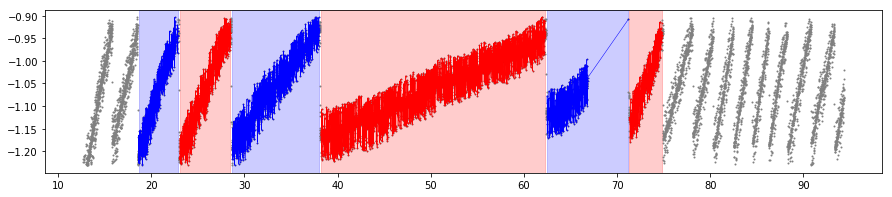

In [425]:
t, x, s, e = determine_regions(time, od, log_od_center, log_od_width, 0.1, drift_tempering_factor=0.25)
len(t), len(x), len(s), len(e)

plt.figure(figsize=(15, 3))

plt.plot(t, x, '.', lw=1, color='gray', ms=2)
colors = ['blue', 'red']
for r, (sr, er) in enumerate(zip(s, e)):
    color = colors[r % len(colors)]
    plt.axvspan(t[sr], t[er], alpha=0.2, color=color)
    plt.plot(t[sr:er+1], x[sr:er+1], '.-', lw=0.5, ms=1, color=color)
plt.show()

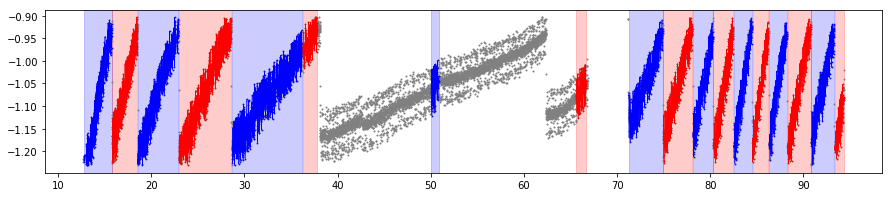

In [428]:
t, x, s, e = determine_regions(time, od, log_od_center, log_od_width, 0.4, drift_tempering_factor=0.25)
len(t), len(x), len(s), len(e)

plt.figure(figsize=(15, 3))

plt.plot(t, x, '.', lw=1, color='gray', ms=2)
colors = ['blue', 'red']
for r, (sr, er) in enumerate(zip(s, e)):
    color = colors[r % len(colors)]
    plt.axvspan(t[sr], t[er], alpha=0.2, color=color)
    plt.plot(t[sr:er+1], x[sr:er+1], '.-', lw=0.5, ms=1, color=color)
plt.show()

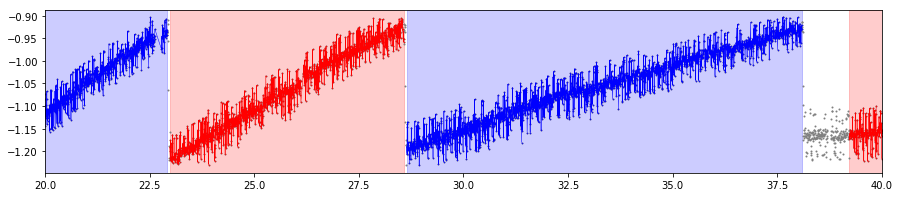

In [407]:
plt.figure(figsize=(15, 3))

plt.plot(t, x, '.', lw=1, color='gray', ms=2)
colors = ['blue', 'red']
for r, (sr, er) in enumerate(zip(s,e)):
    color = colors[r % len(colors)]
    plt.axvspan(t[sr], t[er], alpha=0.2, color=color)
    plt.plot(t[sr:er+1], x[sr:er+1], '.-', lw=0.5, ms=1, color=color)

plt.xlim([20, 40])
plt.show()

In [604]:
np.sum(np.diff(x_segmented) < 0)

1633

In [605]:
np.diff(x_segmented)

array([-0.02238339, -0.01107396,  0.        , ...,  0.        ,
        0.        ,  0.        ])

In [ ]:
def find_jumps(t, x, width, main_freq):
    mu_est = width * main_freq
    number_of_periods = main_freq * (t[-1] - t[0])
    x_drifting = x - mu_est * t
    iso_reg = IsotonicRegression(increasing=False).fit(t, x_drifting)
    
    t_grid = np.linspace(t[0], t[-1], 5 * number_of_periods)
    x_segmented = iso_reg.predict(t_grid)
    
    derivative = np.diff(x_segmented) / np.diff(t_grid)
    t_indexes_after_jump = t_indexes[1:][derivative < - mu_est]
    t_after_jump = t[t_indexes_after_jump]

In [564]:
drifts = np.linspace(0, -2, 100)
jumps = []
for drift in drifts:

    t = time[longest_segment]
    x = np.log(od[longest_segment])

    width = np.sqrt(12) * np.std(x)
    number_of_periods = int(-drift * (t[-1] - t[0]) / width)
    t_grid = np.linspace(t[0], t[-1], 5 * number_of_periods)
    x_drifting = x + drift * t

    iso_reg = IsotonicRegression(increasing=False).fit(t, x_drifting)
    x_segmented = iso_reg.predict(t_grid)

    derivative = np.diff(x_segmented) / np.diff(t_grid)
    jumps.append(np.sum(derivative < 1.5*drift))

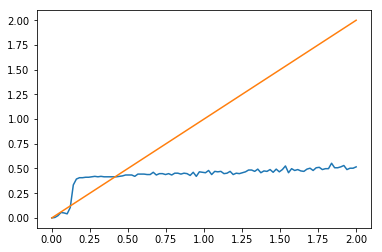

In [566]:
plt.plot(-drifts, jumps / ((t[-1] - t[0]) / width))
plt.plot(-drifts, -drifts)
plt.show()

In [466]:
plt.figure(figsize=(15, 15))
plt.plot(t, x_drifting, '-')
plt.plot(t, x_segmented, 'r-', lw=1)
plt.show()

plt.hist(derivative, bins=50)
plt.axvline(drift, color='r', ls='--', lw=1)
plt.yscale('log')
plt.show()

(218,)

In [467]:
t.shape

(15396,)

In [309]:
def power_specturm(time, signal):
    signal_power_spectrum = np.abs(np.fft.rfft(signal))
    freqs = np.arange(len(signal_power_spectrum)) / (time[-1] - time[0] + time[1] - time[0])
    return (freqs, signal_power_spectrum)

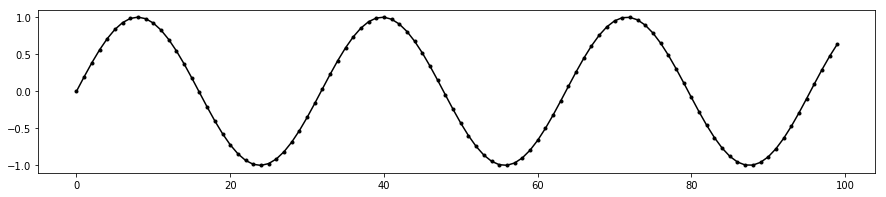

In [421]:
freq = 0.031415
time = np.arange(100)
signal = np.sin(2*np.pi*freq*time) + 0.0 * np.sin(2*np.pi*(2*freq)*time)
plt.figure(figsize=(15,3))
plt.plot(time, signal, 'k.-')
plt.show()

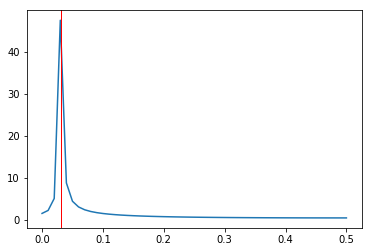

In [427]:
freqs, signal_power_spectrum = power_specturm(time, signal)
plt.plot(freqs, signal_power_spectrum)
plt.axvline(freq, color='r', lw=1)
plt.show()

In [428]:
import nufft

ModuleNotFoundError: No module named 'nufft'

In [425]:
len(signal_power_spectrum)

51

In [423]:
len(time)

100

In [424]:
NufftObj = NUFFT_cpu()
_ = NufftObj.plan(time[:,None], (100,), (100,), (7,))

In [418]:
spectrum = NufftObj.solve(signal,'cg', maxiter=100)

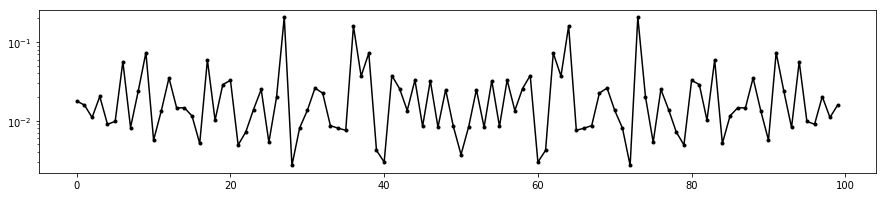

In [419]:
plt.figure(figsize=(15,3))
plt.plot(np.abs(spectrum),'k.-',label='conjugate_gradient_method')
plt.yscale('log')
plt.show()

In [385]:
len(spectrum)

1000

In [377]:
om = np.sort(np.random.randn(1000,1), axis=0)
Nd = (200,) # time grid, tuple
Kd = (200,) # frequency grid, tuple
Jd = (7,) # interpolator 

NufftObj = NUFFT_cpu()
_ = NufftObj.plan(time, Nd, Kd, Jd)

IndexError: too many indices for array

In [367]:
om = np.sort(np.random.randn(200,1), axis=0)
Nd = (256,) # time grid, tuple
Kd = (512,) # frequency grid, tuple
Jd = (7,) # interpolator 

NufftObj = NUFFT_cpu()
_ = NufftObj.plan(om, Nd, Kd, Jd)

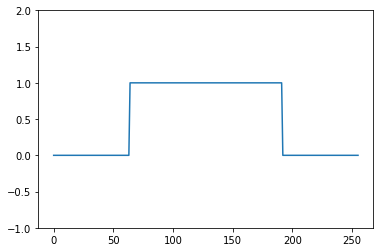

In [340]:
time_data = np.zeros(256, )
time_data[64:192] = 1.0
plt.plot(time_data)
plt.ylim(-1,2)
plt.show()

In [341]:
nufft_freq_data =NufftObj.forward(time_data)

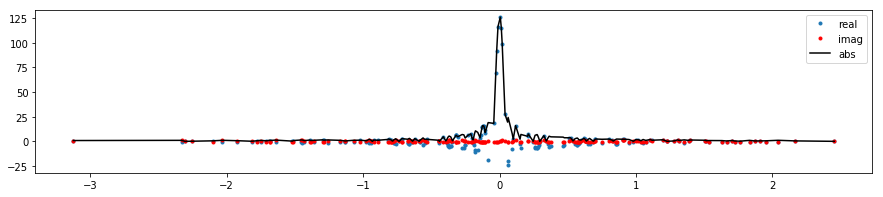

In [343]:
plt.figure(figsize=(15,3))

plt.plot(om, nufft_freq_data.real,'.', label='real')
plt.plot(om, nufft_freq_data.imag,'r.', label='imag')
plt.plot(om, np.abs(nufft_freq_data),'k-', label='abs')

plt.legend()
plt.show()

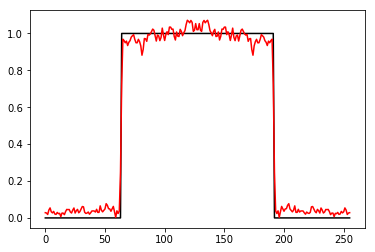

In [353]:
restore_time = NufftObj.solve(nufft_freq_data,'cg', maxiter=100)
im1,=plt.plot(np.abs(time_data),'k',label='original signal')
im4,=plt.plot(np.abs(restore_time),'r',label='conjugate_gradient_method')
plt.show()

In [344]:
from scipy.ndimage.interpolation import shift

In [350]:
shift_by = 10
nufft_freq_data_shifted_real = shift(nufft_freq_data.real, shift_by, cval=0.0)
nufft_freq_data_shifted_imag = shift(nufft_freq_data.imag, shift_by, cval=0.0)
nufft_freq_data_shifted = nufft_freq_data_shifted_real + 1j* nufft_freq_data_shifted_imag

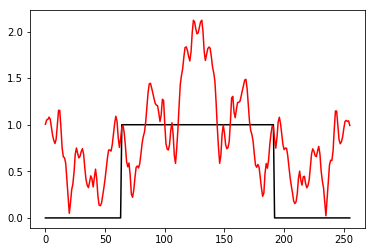

In [354]:
restore_time = NufftObj.solve(nufft_freq_data_shifted,'cg', maxiter=100)
im1,=plt.plot(np.abs(time_data),'k',label='original signal')
im4,=plt.plot(np.abs(restore_time),'r',label='conjugate_gradient_method')
plt.show()

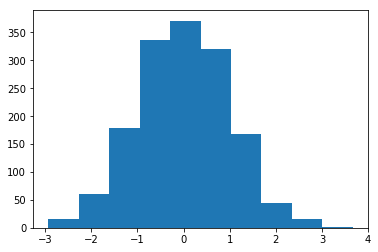

In [224]:
om = np.random.randn(1512,1)

In [221]:
om

array([[ 0.27840058],
       [-0.36272726],
       [ 0.22430588],
       ...,
       [-1.01977124],
       [ 2.04636101],
       [-0.32764301]])

In [111]:
0.0025*60*60

9.0

In [52]:
def plot_data(vial_data_dict):
    plt.figure(figsize=(15, 3))
    od_data = vial_data_dict['OD']
    pump_data = vial_data_dict['pump_log']
    
    plt.plot(od_data['time'], od_data['OD'])
    for t in pump_data['time']:    
        plt.axvline(t, color='r', lw=1)
    
    plt.show()

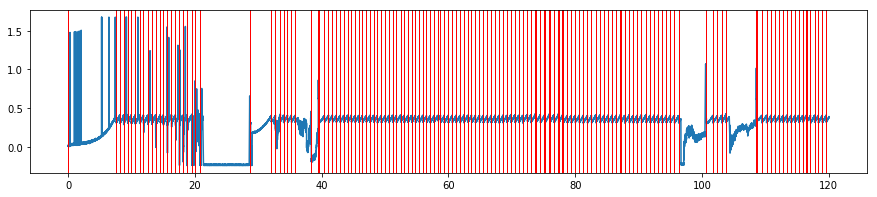

In [53]:
plot_data(data['vial8'])

In [54]:
x_raw = np.array(data['vial8']['OD']['OD'])
t_raw = np.array(data['vial8']['OD']['time'])
x = x_raw[x_raw > 0]
t = t_raw[x_raw > 0]

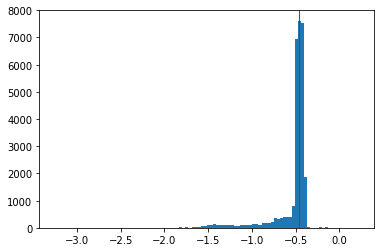

In [81]:
log_OD = np.log10(data['vial8']['OD']['OD'][data['vial8']['OD']['OD'] > 0])
plt.hist(log_OD, bins=100)
plt.axvline(np.median(log_OD), color='r', lw=1)
plt.show()

In [82]:
data_dict = {
    'N': len(log_OD),
    'x': log_OD
}
center0 = np.median(log_OD)
width0 = 2*(np.percentile(log_OD, 75) - np.percentile(log_OD, 25))
m0 = center0
s0 = 3 * width0
w0 = [0.8, 0.2]
result = model.optimizing(data_dict, init=lambda : 
                          {
                              'center': center0,
                              'width': width0,
                              'm': m0,
                              's': s0,
                              'w': w0
                          }
                         )

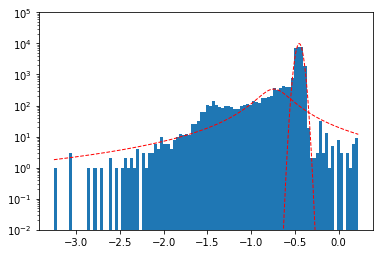

In [83]:
log_OD = np.log10(data['vial8']['OD']['OD'][data['vial8']['OD']['OD'] > 0])
_, bins, _ = plt.hist(log_OD, bins=100)
N = len(log_OD)
b = bins[1] - bins[0]

x = np.linspace(bins[0], bins[-1], 1000)
y_norm = result['w'][0] * norm.pdf(x, loc=result['center'], scale=result['width'])
y_cauchy = result['w'][1] * cauchy.pdf(x, loc=result['m'], scale=result['s'])
# y_floor = result['w'][2] * np.ones_like(x)
# y = y_norm + y_cauchy + y_floor
plt.plot(x, N*b*y_norm, 'r--', lw=1)
plt.plot(x, N*b*y_cauchy, 'r--', lw=1)
# plt.plot(x, N*b*y_floor, 'r--', lw=1)
# plt.plot(x, N*b*y, 'r-', lw=1)

plt.yscale('log')
plt.ylim([1e-2, 1e5])
plt.show()

In [84]:
p_norm = result['w'][0] * norm.pdf(log_OD, loc=result['center'], scale=result['width'])
p_cauchy = result['w'][1] * cauchy.pdf(log_OD, loc=result['m'], scale=result['s'])

selection = p_cauchy < p_norm

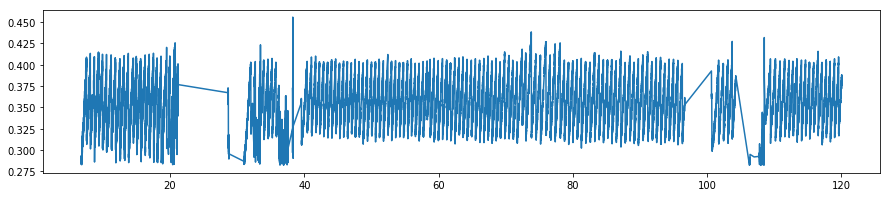

In [87]:
vial_data_dict = data['vial8']

plt.figure(figsize=(15, 3))
plt.plot(vial_data_dict['OD']['time'][data['vial8']['OD']['OD'] > 0][selection], 
         vial_data_dict['OD']['OD'][data['vial8']['OD']['OD'] > 0][selection])
plt.show()

In [64]:
result

OrderedDict([('w', array([0.81248822, 0.18751178])),
             ('center', array(-0.45116858)),
             ('width', array(0.03436019)),
             ('m', array(-0.74193784)),
             ('s', array(0.18389293))])

In [ ]:
def fit_width(log_OD):
    

In [25]:
def saw_tooth(t, freq, width, y0=0):
    return y0 + width * ( (t * freq) % 1 ) - width / 2.0

In [35]:
def calculate_main_freq(t, x):
    x_fft_power = np.abs(np.fft.rfft(x - np.mean(x)))
    main_freq = np.argmax(x_fft_power) / float(t[-1] - t[0])
    return main_freq

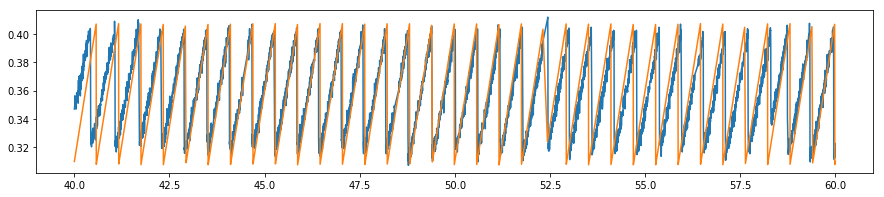

In [37]:
window = (t > 40) & (t < 60)
plt.figure(figsize=(15,3))
main_freq = calculate_main_freq(t[window], x[window])
plt.plot(t[window], x[window], '-')
plt.plot(t[window], saw_tooth(t[window], main_freq, 0.1, y0=np.mean(x[window])))
plt.show()

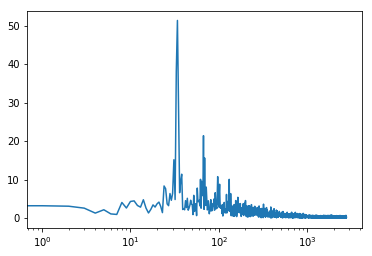

In [39]:
plt.plot(np.abs(np.fft.rfft(x[window] - np.mean(x[window]))))
plt.xscale('log')
plt.show()

In [22]:
t

0          0.0038
1          0.0070
2          0.0189
3          0.0227
4          0.0250
5          0.0288
6          0.0311
7          0.0349
8          0.0372
9          0.0410
10         0.0449
11         0.0471
12         0.0510
13         0.0532
14         0.0571
15         0.0593
16         0.0632
17         0.0671
18         0.0694
19         0.0733
20         0.0755
21         0.0794
22         0.0816
23         0.0855
24         0.0893
25         0.0916
26         0.0955
27         0.0977
28         0.1016
29         0.1038
           ...   
32651    119.9380
32652    119.9419
32653    119.9461
32654    119.9490
32655    119.9529
32656    119.9572
32657    119.9602
32658    119.9639
32659    119.9683
32660    119.9881
32661    119.9909
32662    119.9938
32663    119.9977
32664    120.0016
32665    120.0045
32666    120.0083
32667    120.0128
32668    120.0156
32669    120.0195
32670    120.0239
32671    120.0269
32672    120.0306
32673    120.0349
32674    120.0378
32675    1

In [12]:
len(data['vial8']['pump_log'])

179

In [52]:
np.diff(data['vial15a']['OD']['time'])

array([0.005 , 0.0034, 0.0038, ..., 0.0056, 0.0055, 0.0056])

In [54]:
data['vial15a']['OD']['OD'][data['vial15a']['OD']['OD'] < 0]

2     -0.001349
4     -0.014979
6     -0.012900
8     -0.000238
9     -0.005961
11    -0.000714
14    -0.001747
16    -0.003177
17    -0.000317
23    -0.013539
44    -0.004926
45    -0.000397
47    -0.011302
52    -0.011542
54    -0.007315
74    -0.011143
75    -0.009626
77    -0.010185
84    -0.002859
85    -0.009866
90    -0.010105
91    -0.010344
104   -0.012420
107   -0.011861
110   -0.005165
111   -0.010265
Name: OD, dtype: float64